<a href="https://colab.research.google.com/github/nikbizkit/-/blob/master/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22Lab7_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Лабораторная работа №7

# Задание

Выбрать свой корпус текста и обучить последовательно на нём три архитектуры нейронных сетей на
задаче Next Token Prediction (предсказание следующего токена).

Архитектуры:
* Одномерная свёрточная нейронная сеть
* Рекуррентная нейронная сеть
* Трансформер кодировщик

Визуализировать полученное векторное представление токенов. Сохранить модели в формате onnx.

Дописать код для генерации текста по входной последовательности.

В качестве примера приводится обучение на русском корпусе текста - произведении
Ф.М. Достоевского "Преступление и наказание".

Отчет должен содержать: титульный лист, задание с вариантом корпуса текста, скриншоты и краткие пояснения по каждому этапу лабораторной работы, визуализация векторного представления.


#Контрольные вопросы
1. Предобработка текста
2. Архитектура трансформер
3. Удаление шумовых слов
4. Стемминг и лемматизация
5. Что такое эмбеддинг?

#Выполнение лабораторной работы

## Установка зависимостей

In [2]:
!pip install sentencepiece
!pip install umap-learn
!pip install gdown

     |████████████████████████████████| 1.2 MB 14.8 MB/s 
     |████████████████████████████████| 88 kB 4.8 MB/s 
     |████████████████████████████████| 1.1 MB 11.9 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=bf152569d3013abe16f2dec92cf6995eed3f4e5cd722b7d93454c8b73a088e11
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=48fa0478319858836321b9ff5b2a18517cf779d26ea72bd7981833fa10ab33f1
  Stored in directory: /root/.cache/pip/wheels/7f/2a/f8/7bd5dcec71bd5c669f6f574db3113513696b98f3f9b51f496c
Successfully built umap-learn pynndescent


## Подключение библиотек

In [3]:
from string import punctuation
import math
import time
import os

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from umap import UMAP
import sentencepiece as spm

import torch
import torch.nn as nn
import torch.nn.functional as F

%matplotlib inline

## Где взять датасеты
* https://nlpub.ru/Ресурсы - русские наборы данных

* https://huggingface.co/datasets - мультиязычные наборы данных

* https://avidreaders.ru/books/ - книги в txt 

* https://z-lib.org/ - книги в pdf, txt

* https://pdftotext.com/ - онлайн конвертер из pdf в txt

## Загрузка необработанного корпуса

In [4]:
!gdown --id 1MO6aev-2UUpZlwF0o4ZVGvQLi1YfZhck

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1MO6aev-2UUpZlwF0o4ZVGvQLi1YfZhck
To: /content/prestuplenie-i-nakazanie.txt
100% 1.28M/1.28M [00:00<00:00, 148MB/s]


## Очистка корпуса от пунктуации

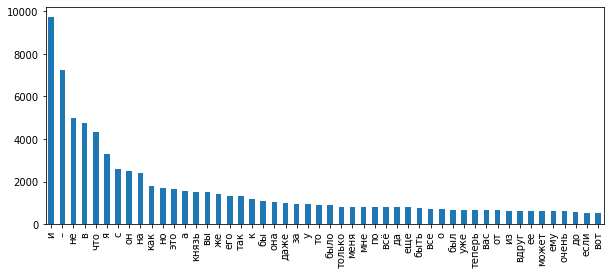

In [4]:
def filter_punctuation(x):
    table = str.maketrans('', '', punctuation)
    x = map(lambda x: x.lower(), x)
    x = map(lambda x: x.translate(table), x)
    x = filter(lambda x: len(x)>0, x)
    return list(x)

FILENAME = 'avidreaders.ru__idiot.txt' 
corpus = []
# encoding может быть один из ['ascii', 'utf-8', 'cp1251']
with open(FILENAME, 'r',
          encoding='utf-8') as f:
    for line in f:
        corpus.extend(list(filter(lambda x: len(x)>0, line.split())))

corpus = filter_punctuation(corpus)
with open('corpus.txt', 'w') as f:
    f.write('\n'.join(corpus))
corpus_df = pd.Series(corpus)
corpus_df.value_counts().head(50).plot(kind='bar', figsize=(10, 4))

## Вывод наиболее частых слов

In [5]:
pd.Series(corpus).value_counts()

и               9739
–               7268
не              4979
в               4761
что             4351
                ... 
площадях           1
перекрестках       1
жаркие             1
откушаютс»         1
братство           1
Length: 29055, dtype: int64

## Обучение токенизатора на корпусе текста
Используется алгоритм [WordPiece](https://paperswithcode.com/method/wordpiece)


In [6]:
spm.SentencePieceTrainer.train(input='corpus.txt', model_prefix='m',
                               vocab_size=10000)

## Проверка токенизатора 

In [7]:
sp = spm.SentencePieceProcessor(model_file='m.model')
prompt = 'это пример токенизации текста'
print(sp.encode_as_ids(prompt)) # == sp.encode 
print(sp.encode_as_pieces(prompt))

[25, 2671, 39, 310, 179, 9253, 11, 1474, 310, 997]
['▁это', '▁пример', '▁то', 'к', 'ен', 'изаци', 'и', '▁те', 'к', 'ста']


## Получение словаря токенов

In [8]:
vocabs = [[sp.id_to_piece(id), id] for id in range(sp.get_piece_size())]
vocabs[:20]

[['<unk>', 0],
 ['<s>', 1],
 ['</s>', 2],
 ['▁', 3],
 ['▁и', 4],
 ['–', 5],
 ['▁не', 6],
 ['а', 7],
 ['▁в', 8],
 ['е', 9],
 ['▁что', 10],
 ['и', 11],
 ['▁с', 12],
 ['▁я', 13],
 ['й', 14],
 ['▁на', 15],
 ['▁он', 16],
 ['у', 17],
 ['м', 18],
 ['▁как', 19]]

## Создание набора данных для задачи Next Token Prediction

In [9]:
def get_window(x):
    XX.append(x.values.copy())
    return 0

WINDOW_SIZE = 16
XX = []
corpus_df = pd.DataFrame(np.concatenate(sp.encode(corpus)))
corpus_df.columns = ['token_ids']
corpus_df['ids'] = corpus_df['token_ids'].factorize(sort=True)[0]
corpus_df['ids'].rolling(WINDOW_SIZE+1).apply(get_window)
table = corpus_df[['token_ids', 'ids']].\
                 drop_duplicates().\
                 sort_values(['ids'], ascending=True).\
                 values
ids2token_ids = {v:k for k,v  in table}

In [10]:
data = np.uint16(XX)
X = data[:, :WINDOW_SIZE].copy()
y = data[:, WINDOW_SIZE:].copy()

indexes = np.random.permutation(y.size)
X = X[indexes].copy()
y = y[indexes].copy()
assert np.unique(X).size == np.unique(y).size, \
    'Уменьшите размер словаря при обучении токенизатора'

## Обучение в Keras (прототипирование)

In [11]:
import tensorflow as tf

inp = tf.keras.layers.Input((WINDOW_SIZE,))
x = tf.keras.layers.Embedding(np.unique(X).size, output_dim=50)(inp)
#x = tf.keras.layers.LSTM(128, return_sequences=False)(x)
#x = tf.keras.layers.Lambda(lambda xx: tf.transpose(xx, perm=[0, 2, 1]))(x)
x = tf.keras.layers.Conv1D(128, (5,), strides=(2,), activation='relu')(x)
x = tf.keras.layers.Conv1D(256, (5,), strides=(2,), activation='relu')(x)
#x = tf.keras.layers.Lambda(lambda xx: tf.transpose(xx, perm=[0, 2, 1]))(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
out = tf.keras.layers.Dense(np.unique(y).size, activation='softmax')(x)

model = tf.keras.models.Model(inp, out)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16)]              0         
                                                                 
 embedding (Embedding)       (None, 16, 50)            499350    
                                                                 
 conv1d (Conv1D)             (None, 6, 128)            32128     
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 256)            164096    
                                                                 
 global_average_pooling1d (G  (None, 256)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 9987)              2566659   
                                                             

In [12]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',
              metrics=['accuracy', tf.keras.metrics.SparseTopKCategoricalAccuracy(5)])
#model = tf.keras.models.load_model('model.h5')

In [13]:
tf.keras.backend.set_value(model.optimizer.lr, 2e-3)
model.fit(X, y, validation_split=0.0, epochs=20, batch_size=1024)

Epoch 1/20
288/288 [==============================] - 19s 23ms/step - loss: 7.0091 - accuracy: 0.0416 - sparse_top_k_categorical_accuracy: 0.1383
Epoch 2/20
288/288 [==============================] - 7s 23ms/step - loss: 6.8245 - accuracy: 0.0453 - sparse_top_k_categorical_accuracy: 0.1432
Epoch 3/20
288/288 [==============================] - 7s 23ms/step - loss: 6.7357 - accuracy: 0.0496 - sparse_top_k_categorical_accuracy: 0.1505
Epoch 4/20
288/288 [==============================] - 7s 23ms/step - loss: 6.6073 - accuracy: 0.0550 - sparse_top_k_categorical_accuracy: 0.1603
Epoch 5/20
288/288 [==============================] - 7s 23ms/step - loss: 6.4364 - accuracy: 0.0628 - sparse_top_k_categorical_accuracy: 0.1710
Epoch 6/20
288/288 [==============================] - 7s 23ms/step - loss: 6.2385 - accuracy: 0.0698 - sparse_top_k_categorical_accuracy: 0.1812
Epoch 7/20
288/288 [==============================] - 7s 23ms/step - loss: 6.0163 - accuracy: 0.0760 - sparse_top_k_categorical_a

In [14]:
model.save('model.h5')

In [15]:
model.get_weights()[0].shape

(9987, 50)

In [16]:
batch_size = 1024
preds = []
for i in tqdm(range(X.shape[0]//batch_size+1)):
    preds.append(model.predict(X[i*batch_size:(i+1)*batch_size].copy()).\
                 argsort(axis=-1)[:, -5:].copy())
preds = np.concatenate(preds)

  0%|          | 0/288 [00:00<?, ?it/s]

In [17]:
for i in range(preds.shape[1]):
    corpus_df['pred@%d'%(i+1)] = -1
    corpus_df.loc[WINDOW_SIZE:, 'pred@%d'%(i+1)] = preds[:,-i]
corpus_df.head(50)

,token_ids,ids,pred@1,pred@2,pred@3,pred@4,pred@5
0,3,1,-1,-1,-1,-1,-1
1,824,821,-1,-1,-1,-1,-1
2,9390,9380,-1,-1,-1,-1,-1
3,1238,1235,-1,-1,-1,-1,-1
4,3714,3709,-1,-1,-1,-1,-1
5,9735,9725,-1,-1,-1,-1,-1
6,45,43,-1,-1,-1,-1,-1
7,3251,3247,-1,-1,-1,-1,-1
8,46,44,-1,-1,-1,-1,-1
9,2006,2002,-1,-1,-1,-1,-1


In [18]:
for col in corpus_df.columns[-preds.shape[1]:]:
    corpus_df[col] = corpus_df[col].apply(lambda x: ids2token_ids.get(x, -1))

In [19]:
sp.decode(corpus_df['pred@1'].tolist()[WINDOW_SIZE:])
#(corpus_df.token_ids==corpus_df[corpus_df.columns[-preds.shape[1]:]])

'ко с мог тебе быть разглядел с что спустя иногда на что него крепко даже лебедева бросил террас успе ней тобой– продолжение в что же или обернул с тут его нака а расхохоталро  с большеоб с вас ика было приехалуже вйаю так и воротао он сам в того одну выражалать...м букв неуже вы верноа руки петрович евгени и простой три не и хочет обратно самии аглая дома это выходя дальше так пить не удивил ве вдругные толькои даже кажется остановила дружб произошл вас с ся таких он в так себя вдруг мои углу иеной себя вас после этун разговор...ть повторилшеля ведь то и весь рогожингода аглая  в меня на друг и в степенизза было себяы я письмомю можно на вама то сам удивлений ис случаеа варвар настась и ответеслия употребля нейве выраженияи что говорит стоит быа совсем впрочем покое и находитьения наверноасьаую дан было с не тот решилите и не неи коляа покля пот  в ичи сильно ноую руку выу кресла» говорит нина чтоееми ничего без довольно вдруг по лизаветвй князял мне даже надо я неае переехав даи прок

In [20]:
#from sklearn.decomposition import PCA
embeddings = UMAP(n_components=2, random_state=2).\
                                          fit_transform(model.get_weights()[0])

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


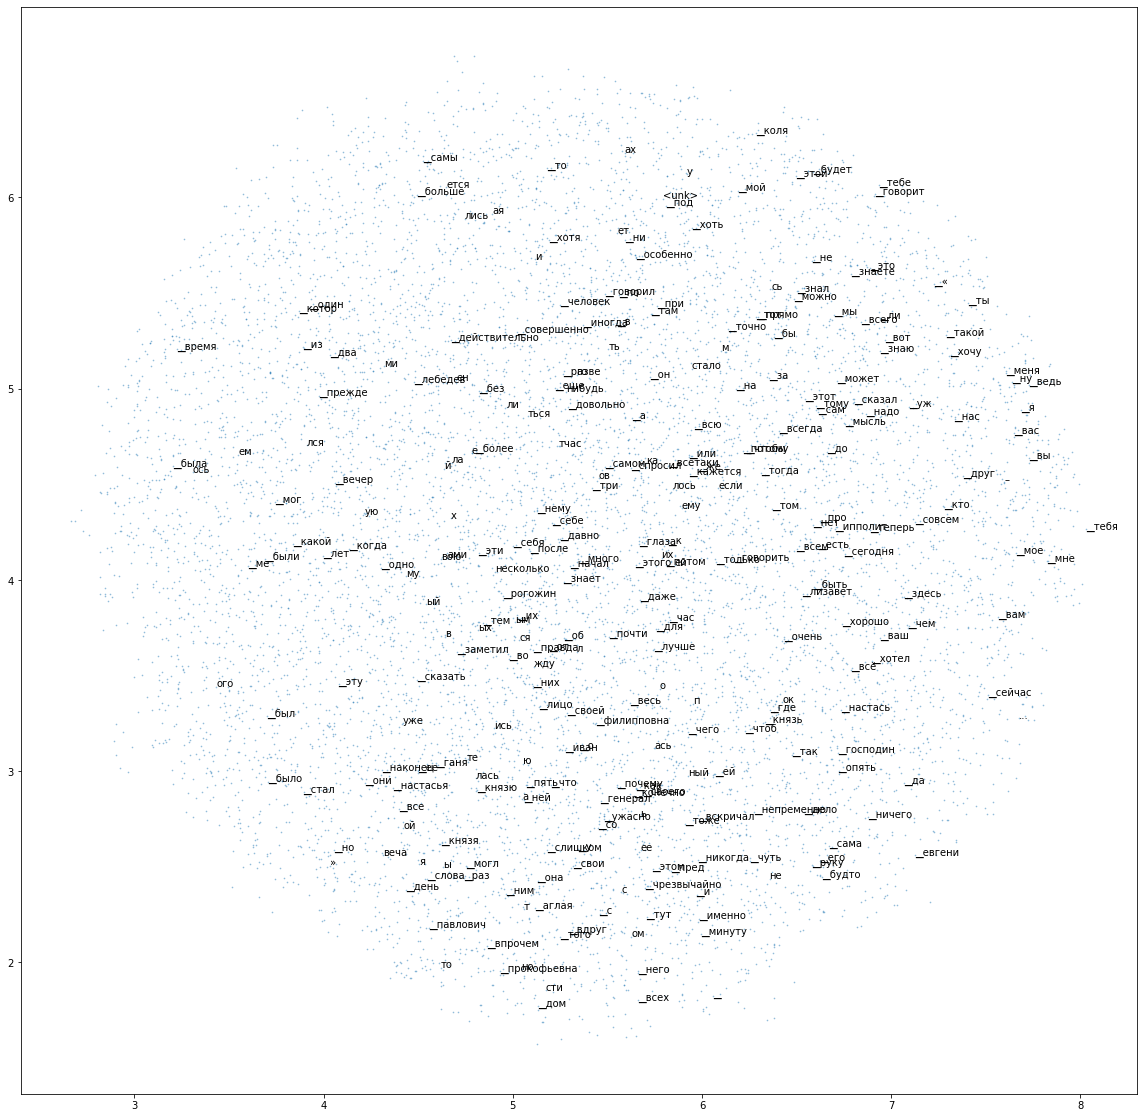

In [21]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.scatter(embeddings[:, 0], embeddings[:, 1], s=0.5, alpha=0.4)

whitelist = frozenset(corpus_df.token_ids.value_counts().index[:300].values)
for i, txt in enumerate(embeddings):
    token_id = ids2token_ids[i]
    if token_id not in whitelist:
        continue
    ax.annotate(vocabs[token_id][0],
                (embeddings[i][0], embeddings[i][1]))
plt.savefig('vecs.svg')

## Обучение в Pytorch
пример основан на

https://github.com/pytorch/examples/tree/master/word_language_model

In [22]:
class ConvModel(nn.Module):
    """Container module with an encoder, a convolutional module, and a decoder."""

    def __init__(self, ntoken, ninp, nhid, dropout=0.1, tie_weights=False):
        super(ConvModel, self).__init__()
        self.ntoken = ntoken
        self.drop = nn.Dropout(dropout)
        self.encoder = nn.Embedding(ntoken, ninp)
        self.conv = nn.Sequential(
                    nn.Conv1d(ninp, nhid//2, 5, stride=3, padding=2, dilation=1),
                    nn.ReLU(),
                    nn.Conv1d(nhid//2, nhid, 5, stride=3, padding=2, dilation=1),
                    nn.ReLU(),
                    nn.Conv1d(nhid, nhid*2, 5, stride=3, padding=2, dilation=1),
                    nn.ReLU(),
                    )
        self.decoder = nn.Linear(nhid*2, ntoken)

        self.init_weights()

        self.nhid = nhid
        self.model_type = 'Conv'

    def init_weights(self):
        initrange = 0.1
        nn.init.uniform_(self.encoder.weight, -initrange, initrange)
        nn.init.zeros_(self.decoder.bias)
        nn.init.uniform_(self.decoder.weight, -initrange, initrange)

    def forward(self, inputs):
        emb = self.drop(self.encoder(inputs))
        emb = emb.transpose(2, 1)
        output = self.conv(emb)
        #print(output.size())
        output = self.drop(output)
        output = output.transpose(2, 1)
        decoded = self.decoder(output)
        #print(decoded.size())
        decoded = decoded.view(-1, self.ntoken)
        return F.log_softmax(decoded, dim=1)


class RNNModel(nn.Module):
    """Container module with an encoder, a recurrent module, and a decoder."""

    def __init__(self, rnn_type, ntoken, ninp, nhid, nlayers, dropout=0.1, tie_weights=False):
        super(RNNModel, self).__init__()
        self.ntoken = ntoken
        self.drop = nn.Dropout(dropout)
        self.encoder = nn.Embedding(ntoken, ninp)
        if rnn_type in ['LSTM', 'GRU']:
            self.rnn = getattr(nn, rnn_type)(ninp, nhid, nlayers, dropout=dropout)
        else:
            try:
                nonlinearity = {'RNN_TANH': 'tanh', 'RNN_RELU': 'relu'}[rnn_type]
            except KeyError:
                raise ValueError( """An invalid option for `--model` was supplied,
                                 options are ['LSTM', 'GRU', 'RNN_TANH' or 'RNN_RELU']""")
            self.rnn = nn.RNN(ninp, nhid, nlayers, nonlinearity=nonlinearity, dropout=dropout)
        self.decoder = nn.Linear(nhid, ntoken)

        # Optionally tie weights as in:
        # "Using the Output Embedding to Improve Language Models" (Press & Wolf 2016)
        # https://arxiv.org/abs/1608.05859
        # and
        # "Tying Word Vectors and Word Classifiers: A Loss Framework for Language Modeling" (Inan et al. 2016)
        # https://arxiv.org/abs/1611.01462
        if tie_weights:
            if nhid != ninp:
                raise ValueError('When using the tied flag, nhid must be equal to emsize')
            self.decoder.weight = self.encoder.weight

        self.init_weights()

        self.rnn_type = rnn_type
        self.nhid = nhid
        self.nlayers = nlayers

    def init_weights(self):
        initrange = 0.1
        nn.init.uniform_(self.encoder.weight, -initrange, initrange)
        nn.init.zeros_(self.decoder.bias)
        nn.init.uniform_(self.decoder.weight, -initrange, initrange)

    def forward(self, input, hidden):
        emb = self.drop(self.encoder(input))
        output, hidden = self.rnn(emb, hidden)
        output = self.drop(output)
        decoded = self.decoder(output)
        decoded = decoded.view(-1, self.ntoken)
        return F.log_softmax(decoded, dim=1), hidden

    def init_hidden(self, bsz):
        weight = next(self.parameters())
        if self.rnn_type == 'LSTM':
            return (weight.new_zeros(self.nlayers, bsz, self.nhid),
                    weight.new_zeros(self.nlayers, bsz, self.nhid))
        else:
            return weight.new_zeros(self.nlayers, bsz, self.nhid)

# Temporarily leave PositionalEncoding module here. Will be moved somewhere else.
class PositionalEncoding(nn.Module):
    r"""Inject some information about the relative or absolute position of the tokens in the sequence.
        The positional encodings have the same dimension as the embeddings, so that the two can be summed.
        Here, we use sine and cosine functions of different frequencies.
    .. math:
        \text{PosEncoder}(pos, 2i) = sin(pos/10000^(2i/d_model))
        \text{PosEncoder}(pos, 2i+1) = cos(pos/10000^(2i/d_model))
        \text{where pos is the word position and i is the embed idx)
    Args:
        d_model: the embed dim (required).
        dropout: the dropout value (default=0.1).
        max_len: the max. length of the incoming sequence (default=5000).
    Examples:
        >>> pos_encoder = PositionalEncoding(d_model)
    """

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        r"""Inputs of forward function
        Args:
            x: the sequence fed to the positional encoder model (required).
        Shape:
            x: [sequence length, batch size, embed dim]
            output: [sequence length, batch size, embed dim]
        Examples:
            >>> output = pos_encoder(x)
        """

        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class TransformerModel(nn.Module):
    """Container module with an encoder, a recurrent or transformer module, and a decoder."""

    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, dropout=0.1):
        super(TransformerModel, self).__init__()
        try:
            from torch.nn import TransformerEncoder, TransformerEncoderLayer
        except:
            raise ImportError('TransformerEncoder module does not exist in PyTorch 1.1 or lower.')
        self.model_type = 'Transformer'
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(ninp, dropout)
        encoder_layers = TransformerEncoderLayer(ninp, nhead, nhid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntoken, ninp)
        self.ninp = ninp
        self.decoder = nn.Linear(ninp, ntoken)

        self.init_weights()

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        # https://github.com/pytorch/pytorch/issues/28508
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 0.1
        nn.init.uniform_(self.encoder.weight, -initrange, initrange)
        nn.init.zeros_(self.decoder.bias)
        nn.init.uniform_(self.decoder.weight, -initrange, initrange)

    def forward(self, src, has_mask=True):
        if has_mask:
            device = src.device
            if self.src_mask is None or self.src_mask.size(0) != len(src):
                mask = self._generate_square_subsequent_mask(len(src)).to(device)
                self.src_mask = mask
        else:
            self.src_mask = None
        #src = src.type(torch.int64)
        
        src = self.encoder(src) * math.sqrt(self.ninp)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, self.src_mask)
        output = self.decoder(output)
        return F.log_softmax(output, dim=-1)

In [23]:
###############################################################################
# Training code
###############################################################################

def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""

    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)


# get_batch subdivides the source data into chunks of length args.bptt.
# If source is equal to the example output of the batchify function, with
# a bptt-limit of 2, we'd get the following two Variables for i = 0:
# ┌ a g m s ┐ ┌ b h n t ┐
# └ b h n t ┘ └ c i o u ┘
# Note that despite the name of the function, the subdivison of data is not
# done along the batch dimension (i.e. dimension 1), since that was handled
# by the batchify function. The chunks are along dimension 0, corresponding
# to the seq_len dimension in the LSTM.

def get_batch(source, i):
    seq_len = min(bptt, len(y) - 1 - i)
    return torch.LongTensor(X[i:i+seq_len].astype(np.int32)).to(device), \
           torch.LongTensor(y[i:i+seq_len].astype(np.int32)).to(device)


def evaluate(data_source):
    # Turn on evaluation mode which disables dropout.
    model.eval()
    total_loss = 0.
    ntokens = np.unique(y).size
    model_types = frozenset(['Transformer', 'Conv'])

    if model_type not in model_types:
        hidden = model.init_hidden(WINDOW_SIZE)
    with torch.no_grad():
        for i in range(0, y.size - 1, bptt):
            data, targets = get_batch(y, i)
            if model_type == 'Transformer':
                output = model(data)
                output = output[:, -1, :]
            elif model_type == 'Conv':
                output = model(data)
                output = output.view(data.size()[0], -1, ntokens)[:, -1]
            else:
                output, hidden = model(data, hidden)
                hidden = repackage_hidden(hidden)
                output = output.view(-1, WINDOW_SIZE, ntokens)[:, -1]
            #print(output.size())
            total_loss += len(data) * criterion(output, targets.squeeze(1)).item()
    return total_loss / (len(data_source) - 1)


def train(batch_size=128):
    # Turn on training mode which enables dropout.
    model.train()
    total_loss = 0.
    start_time = time.time()
    ntokens = np.unique(y).size
    model_types = frozenset(['Transformer', 'Conv'])
    if model_type not in model_types:
        hidden = model.init_hidden(WINDOW_SIZE)
    for batch, i in enumerate(range(0, y.size - 1, bptt)):
        data, targets = get_batch(y, i)
        # Starting each batch, we detach the hidden state from how it was previously produced.
        # If we didn't, the model would try backpropagating all the way to start of the dataset.
        model.zero_grad()
        if model_type == 'Transformer':
            output = model(data)
            #output = output.view(-1, ntokens)
            output = output[:, -1]
        elif model_type == 'Conv':
            output = model(data)
            output = output.view(data.size()[0], -1, ntokens)[:, -1]
        else:
            hidden = repackage_hidden(hidden)
            output, hidden = model(data, hidden)
            output = output.view(-1, WINDOW_SIZE, ntokens)[:, -1]
        loss = criterion(output, targets.squeeze(1))
        loss.backward()

        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        for p in model.parameters():
            p.data.add_(p.grad, alpha=-lr)

        total_loss += loss.item()

        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | lr {:02.2f} | ms/batch {:5.3f} | '
                    'loss {:5.2f} | ppl {:8.2f}'.format(
                epoch, batch, len(y) // bptt, lr,
                elapsed * 1000 / log_interval, cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()
        if dry_run:
            break


def export_onnx(path, batch_size, seq_len):
    print('The model is also exported in ONNX format at {}.'.format(os.path.realpath(path)))
    model.eval()
    dummy_input = torch.LongTensor(seq_len * batch_size).zero_().view(-1, seq_len).to(device)
    inputs = dummy_input
    model_types = frozenset(['Transformer', 'Conv'])
    if model_type not in model_types:
        hidden = model.init_hidden(WINDOW_SIZE)
        inputs = (dummy_input, hidden)
    torch.onnx.export(model, inputs, path, opset_version=10)

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Обучение свёрточной модели Conv1d

In [26]:
model = ConvModel(np.unique(y).size, 128, 192, 0.1).to(device)
criterion = nn.NLLLoss()
model

ConvModel(
  (drop): Dropout(p=0.1, inplace=False)
  (encoder): Embedding(9987, 128)
  (conv): Sequential(
    (0): Conv1d(128, 96, kernel_size=(5,), stride=(3,), padding=(2,))
    (1): ReLU()
    (2): Conv1d(96, 192, kernel_size=(5,), stride=(3,), padding=(2,))
    (3): ReLU()
    (4): Conv1d(192, 384, kernel_size=(5,), stride=(3,), padding=(2,))
    (5): ReLU()
  )
  (decoder): Linear(in_features=384, out_features=9987, bias=True)
)

In [27]:
model_type = 'Conv'
lr = 1
bptt = 64
eval_batch_size = bptt
clip = 0.1
log_interval = 100
dry_run = False

### Вывод числа параметров

In [28]:
print(*[(k, p.view(-1).size()[0]) for k, p in model.named_parameters()],
      sep='\n')
print('Всего: {:,}'.format(sum(p.view(-1).size()[0] for k, p in model.named_parameters())))

('encoder.weight', 1278336)
('conv.0.weight', 61440)
('conv.0.bias', 96)
('conv.2.weight', 92160)
('conv.2.bias', 192)
('conv.4.weight', 368640)
('conv.4.bias', 384)
('decoder.weight', 3835008)
('decoder.bias', 9987)
Всего: 5,646,243


### Проверка прямого прохода модели

In [29]:
model(torch.ones((32, 16)).type(torch.int64).to(device)).size()

torch.Size([32, 9987])

### Замер времени прохождения по всему корпусу

In [30]:
%%time
evaluate(y)

CPU times: user 3.96 s, sys: 10.2 ms, total: 3.97 s
Wall time: 4 s


9.209629945277314

### Обучение модели

In [31]:
# Loop over epochs.
epochs = 40
best_val_loss = None
savefile = '%s_next_token.pt'%model_type

patience_max = 1
patience = 0
# At any point you can hit Ctrl + C to break out of training early.
try:
    for epoch in range(1, epochs+1):
        epoch_start_time = time.time()
        train()
        val_loss = evaluate(y)
        print('-' * 89)
        print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.3f} | '
                'valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                           val_loss, math.exp(val_loss)))
        print('-' * 89)
        # Save the model if the validation loss is the best we've seen so far.
        if not best_val_loss or val_loss < best_val_loss:
            with open(savefile, 'wb') as f:
                torch.save(model, f)
            best_val_loss = val_loss
            patience = 0
        else:
            patience += 1
            if patience < patience_max: continue 
            with open(savefile, 'rb') as f:
                model = torch.load(f)
            # Anneal the learning rate if no improvement has been seen in the validation dataset.
            lr /= 2.0
            patience = 0
except KeyboardInterrupt:
    print('-' * 89)
    print('Exiting from training early')

| epoch   1 |   100/ 4594 batches | lr 1.00 | ms/batch 7.020 | loss  8.53 | ppl  5041.10
| epoch   1 |   200/ 4594 batches | lr 1.00 | ms/batch 4.030 | loss  7.42 | ppl  1666.60
| epoch   1 |   300/ 4594 batches | lr 1.00 | ms/batch 4.096 | loss  7.31 | ppl  1488.83
| epoch   1 |   400/ 4594 batches | lr 1.00 | ms/batch 4.035 | loss  7.17 | ppl  1297.39
| epoch   1 |   500/ 4594 batches | lr 1.00 | ms/batch 4.067 | loss  7.11 | ppl  1219.95
| epoch   1 |   600/ 4594 batches | lr 1.00 | ms/batch 4.096 | loss  7.07 | ppl  1174.09
| epoch   1 |   700/ 4594 batches | lr 1.00 | ms/batch 3.984 | loss  7.02 | ppl  1118.10
| epoch   1 |   800/ 4594 batches | lr 1.00 | ms/batch 4.053 | loss  7.05 | ppl  1157.40
| epoch   1 |   900/ 4594 batches | lr 1.00 | ms/batch 3.992 | loss  7.02 | ppl  1121.46
| epoch   1 |  1000/ 4594 batches | lr 1.00 | ms/batch 4.073 | loss  6.98 | ppl  1071.92
| epoch   1 |  1100/ 4594 batches | lr 1.00 | ms/batch 4.078 | loss  6.97 | ppl  1065.38
| epoch   1 |  1200/ 

### Проверка качества, экспорт в ONNX

In [32]:
# Загрузка лучшей модели.
with open(savefile, 'rb') as f:
    model = torch.load(f)
    # после загрузки параметры RNN находятся не в одном сегменте памяти
    # для помещения в один участок и ускорения прямого прохода
    # В настоящее время, только рекуррентная модель поддерживает flatten_parameters.
    if model_type in ['RNN_TANH', 'RNN_RELU', 'LSTM', 'GRU']:
        model.rnn.flatten_parameters()

# Финальная проверка качества
test_loss = evaluate(y)
print('=' * 89)
print('| End of training | test loss {:5.2f} | test ppl {:8.3f}'.format(
    test_loss, math.exp(test_loss)))
print('=' * 89)

onnx_export = '%s_next_token.onnx'%(model_type)
if len(onnx_export) > 0:
    # Экспортирование модели в формат ONNX
    export_onnx(onnx_export, batch_size=1, seq_len=WINDOW_SIZE)

| End of training | test loss  4.65 | test ppl  104.445
The model is also exported in ONNX format at /content/Conv_next_token.onnx.


### Получение эмбеддингов, проекция на 2D

In [33]:
#from sklearn.decomposition import PCA
embeddings = list(model.encoder.parameters())[0].detach().cpu().numpy()

embeddings = UMAP(n_components=2, random_state=2).fit_transform(embeddings)

### Визуализация пространства эмбеддингов

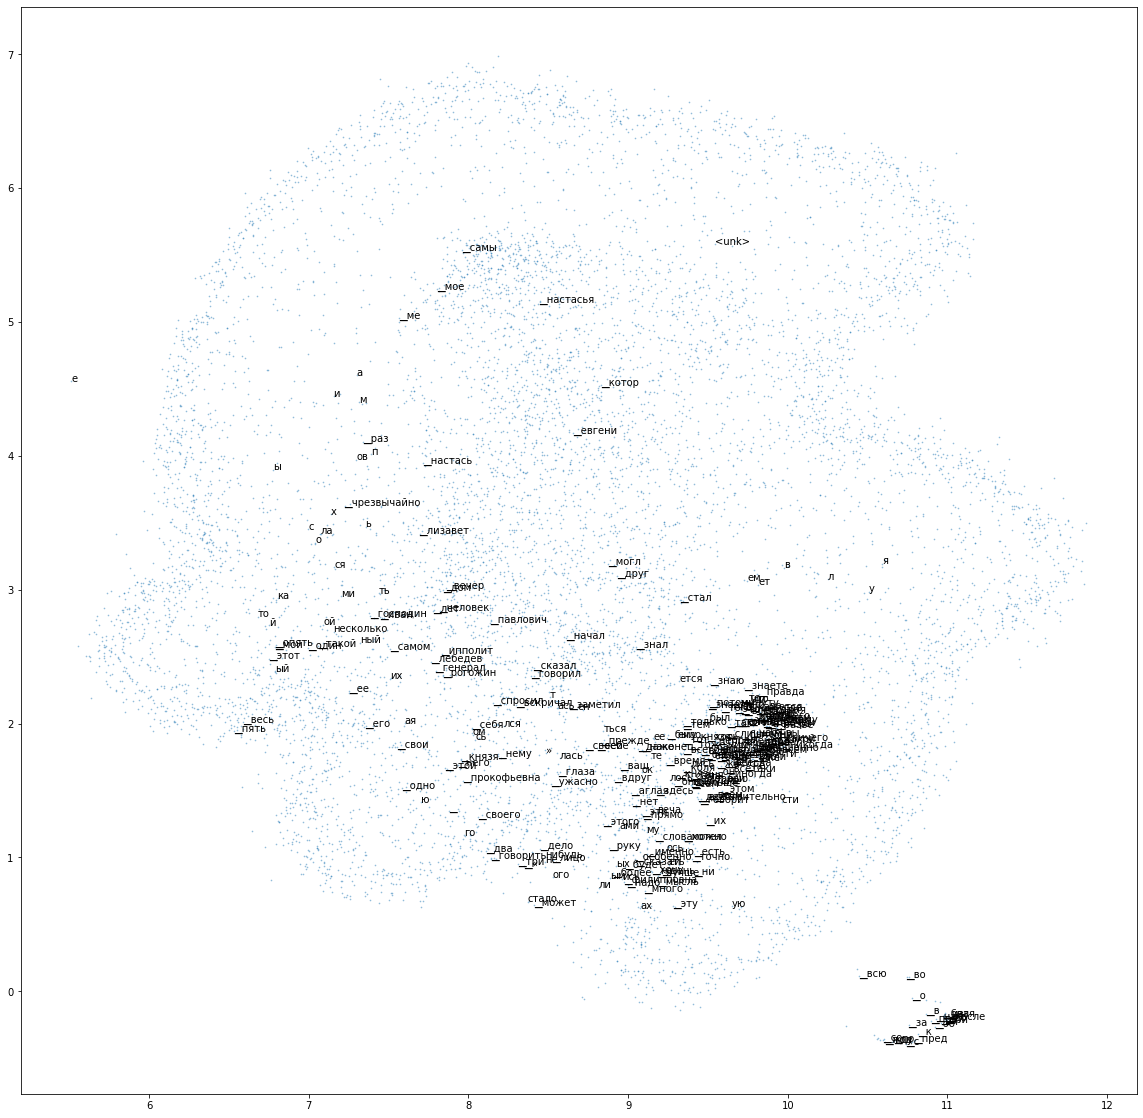

In [34]:
# Визуализация обученных эмбеддингов
fig, ax = plt.subplots(figsize=(20, 20))
ax.scatter(embeddings[:, 0], embeddings[:, 1], s=0.5, alpha=0.4)

# берём 300 наиболее частых
whitelist = frozenset(corpus_df.token_ids.value_counts().index[:300].values)
for i, txt in enumerate(embeddings):
    token_id = ids2token_ids[i]
    if token_id not in whitelist:
        continue
    ax.annotate(vocabs[token_id][0],
                (embeddings[i][0], embeddings[i][1]))
plt.savefig('vecs_%s.svg'%model_type)

## Обучение рекуррентной модели LSTM

In [35]:
model = RNNModel('LSTM', np.unique(y).size, 50, 256, 2, 0.1, False).to(device)
criterion = nn.NLLLoss()
model

RNNModel(
  (drop): Dropout(p=0.1, inplace=False)
  (encoder): Embedding(9987, 50)
  (rnn): LSTM(50, 256, num_layers=2, dropout=0.1)
  (decoder): Linear(in_features=256, out_features=9987, bias=True)
)

In [36]:
model_type = 'LSTM'
lr=10
bptt = 1024
eval_batch_size = bptt
clip = 0.25
log_interval = 10
dry_run = False

### Вывод числа параметров

In [37]:
print(*[(k, p.view(-1).size()[0]) for k, p in model.named_parameters()],
      sep='\n')
print('Всего: {:,}'.format(sum(p.view(-1).size()[0] for k, p in model.named_parameters())))

('encoder.weight', 499350)
('rnn.weight_ih_l0', 51200)
('rnn.weight_hh_l0', 262144)
('rnn.bias_ih_l0', 1024)
('rnn.bias_hh_l0', 1024)
('rnn.weight_ih_l1', 262144)
('rnn.weight_hh_l1', 262144)
('rnn.bias_ih_l1', 1024)
('rnn.bias_hh_l1', 1024)
('decoder.weight', 2556672)
('decoder.bias', 9987)
Всего: 3,907,737


### Замер времени прохождения по всему корпусу

In [38]:
%%time
evaluate(y)

CPU times: user 18.1 s, sys: 17.2 ms, total: 18.1 s
Wall time: 18.1 s


9.20749352866478

### Обучение модели

In [39]:
# Loop over epochs.
epochs = 30
best_val_loss = None
savefile = '%s_next_token.pt'%model_type

# At any point you can hit Ctrl + C to break out of training early.
try:
    for epoch in range(1, epochs+1):
        epoch_start_time = time.time()
        train()
        val_loss = evaluate(y)
        print('-' * 89)
        print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.3f} | '
                'valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                           val_loss, math.exp(val_loss)))
        print('-' * 89)
        # Save the model if the validation loss is the best we've seen so far.
        if not best_val_loss or val_loss < best_val_loss:
            with open(savefile, 'wb') as f:
                torch.save(model, f)
            best_val_loss = val_loss
        else:
            # Anneal the learning rate if no improvement has been seen in the validation dataset.
            lr /= 2.0
except KeyboardInterrupt:
    print('-' * 89)
    print('Exiting from training early')

| epoch   1 |    10/  287 batches | lr 10.00 | ms/batch 190.535 | loss  9.46 | ppl 12773.14
| epoch   1 |    20/  287 batches | lr 10.00 | ms/batch 165.283 | loss  7.78 | ppl  2382.23
| epoch   1 |    30/  287 batches | lr 10.00 | ms/batch 164.401 | loss  7.65 | ppl  2104.57
| epoch   1 |    40/  287 batches | lr 10.00 | ms/batch 165.804 | loss  7.35 | ppl  1548.62
| epoch   1 |    50/  287 batches | lr 10.00 | ms/batch 165.173 | loss  7.33 | ppl  1525.41
| epoch   1 |    60/  287 batches | lr 10.00 | ms/batch 165.684 | loss  7.22 | ppl  1370.51
| epoch   1 |    70/  287 batches | lr 10.00 | ms/batch 166.126 | loss  7.15 | ppl  1280.30
| epoch   1 |    80/  287 batches | lr 10.00 | ms/batch 166.481 | loss  7.17 | ppl  1301.09
| epoch   1 |    90/  287 batches | lr 10.00 | ms/batch 166.677 | loss  7.07 | ppl  1180.89
| epoch   1 |   100/  287 batches | lr 10.00 | ms/batch 166.510 | loss  7.08 | ppl  1191.68
| epoch   1 |   110/  287 batches | lr 10.00 | ms/batch 166.002 | loss  7.09 | p

### Проверка качества, экспорт в ONNX

In [40]:
# Загрузка лучшей модели.
with open(savefile, 'rb') as f:
    model = torch.load(f)
    # после загрузки параметры RNN находятся не в одном сегменте памяти
    # для помещения в один участок и ускорения прямого прохода
    # В настоящее время, только рекуррентная модель поддерживает flatten_parameters.
    if model_type in ['RNN_TANH', 'RNN_RELU', 'LSTM', 'GRU']:
        model.rnn.flatten_parameters()

# Финальная проверка качества
test_loss = evaluate(y)
print('=' * 89)
print('| End of training | test loss {:5.2f} | test ppl {:8.3f}'.format(
    test_loss, math.exp(test_loss)))
print('=' * 89)

onnx_export = '%s_next_token.onnx'%(model_type)
if len(onnx_export) > 0:
    # Экспортирование модели в формат ONNX
    export_onnx(onnx_export, batch_size=1, seq_len=WINDOW_SIZE)

| End of training | test loss  4.50 | test ppl   89.622
The model is also exported in ONNX format at /content/LSTM_next_token.onnx.


/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_opset9.py:2192: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  "or define the initial states (h0/c0) as inputs of the model. ")


### Получение эмбеддингов, проекция на 2D

In [41]:
#from sklearn.decomposition import PCA
embeddings = list(model.encoder.parameters())[0].detach().cpu().numpy()

embeddings = UMAP(n_components=2, random_state=2).fit_transform(embeddings)

### Визуализация пространства эмбеддингов

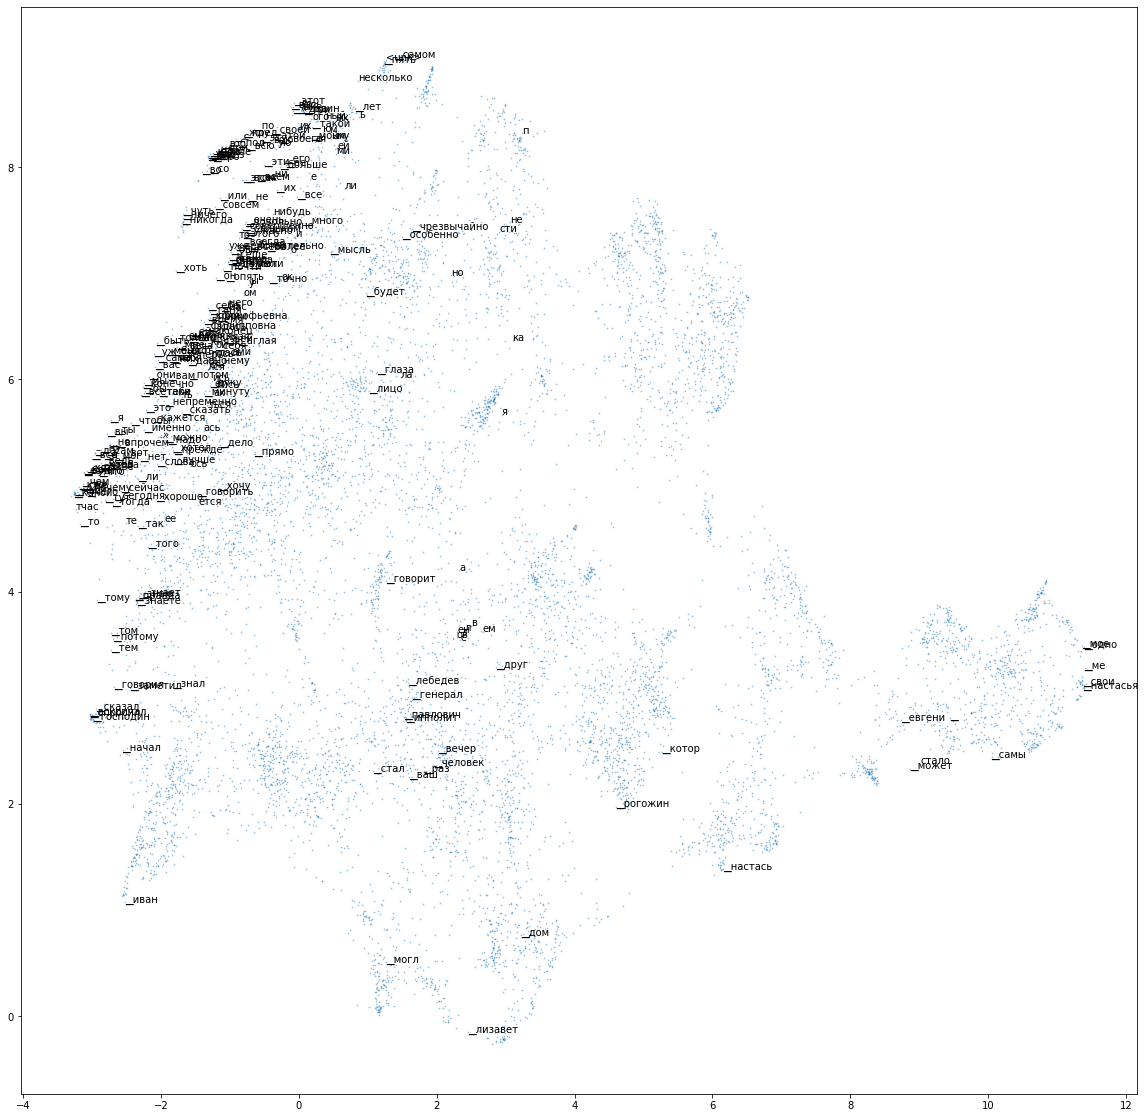

In [42]:
# Визуализация обученных эмбеддингов
fig, ax = plt.subplots(figsize=(20, 20))
ax.scatter(embeddings[:, 0], embeddings[:, 1], s=0.5, alpha=0.4)

# берём 300 наиболее частых
whitelist = frozenset(corpus_df.token_ids.value_counts().index[:300].values)
for i, txt in enumerate(embeddings):
    token_id = ids2token_ids[i]
    if token_id not in whitelist:
        continue
    ax.annotate(vocabs[token_id][0],
                (embeddings[i][0], embeddings[i][1]))
plt.savefig('vecs_%s.svg'%model_type)

## Обучение модели self-attention

In [43]:
model = TransformerModel(np.unique(y).size, 128+32, 4, 192, 2, 0.1).to(device)
# ntoken, ninp, nhead, nhid, nlayers, dropout
criterion = nn.NLLLoss()
model

TransformerModel(
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=160, out_features=160, bias=True)
        )
        (linear1): Linear(in_features=160, out_features=192, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=192, out_features=160, bias=True)
        (norm1): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=160, out_features=160, bias=True)
        )
        

In [44]:
model_type = 'Transformer'
lr = 2.0
bptt = 64
eval_batch_size = bptt
clip = 0.25
log_interval = 100
dry_run = False

### Вывод числа параметров

In [45]:
print(*[(k, p.view(-1).size()[0]) for k, p in model.named_parameters()],
      sep='\n')
print('Всего: {:,}'.format(sum(p.view(-1).size()[0] for k, p in model.named_parameters())))

('transformer_encoder.layers.0.self_attn.in_proj_weight', 76800)
('transformer_encoder.layers.0.self_attn.in_proj_bias', 480)
('transformer_encoder.layers.0.self_attn.out_proj.weight', 25600)
('transformer_encoder.layers.0.self_attn.out_proj.bias', 160)
('transformer_encoder.layers.0.linear1.weight', 30720)
('transformer_encoder.layers.0.linear1.bias', 192)
('transformer_encoder.layers.0.linear2.weight', 30720)
('transformer_encoder.layers.0.linear2.bias', 160)
('transformer_encoder.layers.0.norm1.weight', 160)
('transformer_encoder.layers.0.norm1.bias', 160)
('transformer_encoder.layers.0.norm2.weight', 160)
('transformer_encoder.layers.0.norm2.bias', 160)
('transformer_encoder.layers.1.self_attn.in_proj_weight', 76800)
('transformer_encoder.layers.1.self_attn.in_proj_bias', 480)
('transformer_encoder.layers.1.self_attn.out_proj.weight', 25600)
('transformer_encoder.layers.1.self_attn.out_proj.bias', 160)
('transformer_encoder.layers.1.linear1.weight', 30720)
('transformer_encoder.lay

### Замер времени прохождения по всему корпусу

In [46]:
%%time
evaluate(y)

CPU times: user 14.3 s, sys: 15.3 ms, total: 14.3 s
Wall time: 14.3 s


9.43095936440687

### Обучение модели

In [47]:
# Loop over epochs.
epochs = 40
best_val_loss = None
savefile = '%s_next_token.pt'%model_type

patience_max = 2
patience = 0
# At any point you can hit Ctrl + C to break out of training early.
try:
    for epoch in range(1, epochs+1):
        epoch_start_time = time.time()
        train()
        val_loss = evaluate(y)
        print('-' * 89)
        print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.3f} | '
                'valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                           val_loss, math.exp(val_loss)))
        print('-' * 89)
        # Save the model if the validation loss is the best we've seen so far.
        if not best_val_loss or val_loss < best_val_loss:
            with open(savefile, 'wb') as f:
                torch.save(model, f)
            best_val_loss = val_loss
            patience = 0
        else:
            patience += 1
            if patience < patience_max: continue 
            with open(savefile, 'rb') as f:
                model = torch.load(f)
            # Anneal the learning rate if no improvement has been seen in the validation dataset.
            lr /= 2.0
            patience = 0
except KeyboardInterrupt:
    print('-' * 89)
    print('Exiting from training early')

| epoch   1 |   100/ 4594 batches | lr 2.00 | ms/batch 9.814 | loss  7.60 | ppl  2000.10
| epoch   1 |   200/ 4594 batches | lr 2.00 | ms/batch 9.160 | loss  7.06 | ppl  1161.65
| epoch   1 |   300/ 4594 batches | lr 2.00 | ms/batch 9.084 | loss  6.96 | ppl  1050.23
| epoch   1 |   400/ 4594 batches | lr 2.00 | ms/batch 9.078 | loss  6.83 | ppl   925.58
| epoch   1 |   500/ 4594 batches | lr 2.00 | ms/batch 9.082 | loss  6.72 | ppl   828.89
| epoch   1 |   600/ 4594 batches | lr 2.00 | ms/batch 9.062 | loss  6.67 | ppl   787.67
| epoch   1 |   700/ 4594 batches | lr 2.00 | ms/batch 9.034 | loss  6.56 | ppl   707.68
| epoch   1 |   800/ 4594 batches | lr 2.00 | ms/batch 9.111 | loss  6.59 | ppl   728.06
| epoch   1 |   900/ 4594 batches | lr 2.00 | ms/batch 9.056 | loss  6.51 | ppl   670.42
| epoch   1 |  1000/ 4594 batches | lr 2.00 | ms/batch 9.090 | loss  6.44 | ppl   628.78
| epoch   1 |  1100/ 4594 batches | lr 2.00 | ms/batch 9.062 | loss  6.41 | ppl   606.75
| epoch   1 |  1200/ 

### Проверка качества, экспорт в ONNX

In [48]:
# Загрузка лучшей модели.
with open(savefile, 'rb') as f:
    model = torch.load(f)
    # после загрузки параметры RNN находятся не в одном сегменте памяти
    # для помещения в один участок и ускорения прямого прохода
    # В настоящее время, только рекуррентная модель поддерживает flatten_parameters.
    if model_type in ['RNN_TANH', 'RNN_RELU', 'LSTM', 'GRU']:
        model.rnn.flatten_parameters()

# Финальная проверка качества
test_loss = evaluate(y)
print('=' * 89)
print('| End of training | test loss {:5.2f} | test ppl {:8.3f}'.format(
    test_loss, math.exp(test_loss)))
print('=' * 89)

onnx_export = '%s_next_token.onnx'%(model_type)
if len(onnx_export) > 0:
    # Экспортирование модели в формат ONNX
    export_onnx(onnx_export, batch_size=1, seq_len=WINDOW_SIZE)

| End of training | test loss  2.39 | test ppl   10.936
The model is also exported in ONNX format at /content/Transformer_next_token.onnx.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:179: TracerWarning: Using len to get tensor shape might cause the trace to be incorrect. Recommended usage would be tensor.shape[0]. Passing a tensor of different shape might lead to errors or silently give incorrect results.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:179: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:180: TracerWarning: Using len to get tensor shape might cause the trace to be incorrect. Recommended usage would be tensor.shape[0]. Passing a tensor of different shape might lead to errors or silently give incorrect results.


### Получение эмбеддингов, проекция в 2D

In [49]:
#from sklearn.decomposition import PCA
embeddings = list(model.encoder.parameters())[0].detach().cpu().numpy()

embeddings = UMAP(n_components=2, random_state=2).fit_transform(embeddings)

### Визуализация пространства эмбеддингов

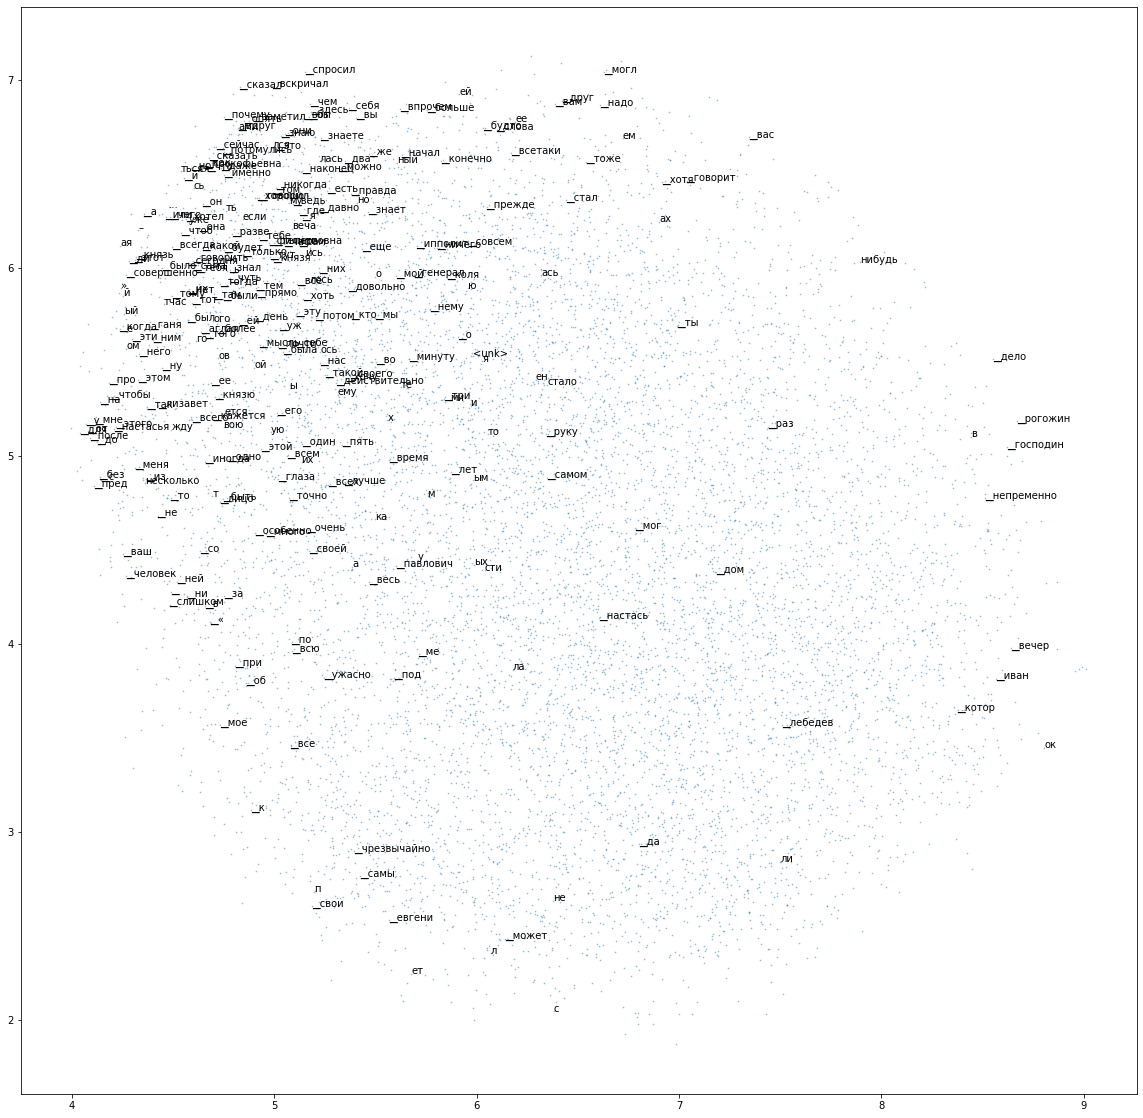

In [50]:
# Визуализация обученных эмбеддингов
fig, ax = plt.subplots(figsize=(20, 20))
ax.scatter(embeddings[:, 0], embeddings[:, 1], s=0.5, alpha=0.4)

# берём 300 наиболее частых
whitelist = frozenset(corpus_df.token_ids.value_counts().index[:300].values)
for i, txt in enumerate(embeddings):
    token_id = ids2token_ids[i]
    if token_id not in whitelist:
        continue
    ax.annotate(vocabs[token_id][0],
                (embeddings[i][0], embeddings[i][1]))
plt.savefig('vecs_%s.svg'%model_type)